# Cancer Death Rate Prediction by Cancer Type
Predict cancer-specific death rate per 100,000 people using **Random Forest** and **Decision Tree** models.

In [ ]:

!pip install pandas scikit-learn joblib

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
plt.style.use('Solarize_Light2')
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from tabulate import tabulate
from IPython.display import display,HTML

In [ ]:
# Load and Prepare Data
df = pd.read_csv('cancer-death-rates-by-type.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6840 entries, 0 to 6839
Data columns (total 25 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   Entity                                                                                       6840 non-null   object 
 1   Code                                                                                         6150 non-null   object 
 2   Year                                                                                         6840 non-null   int64  
 3   Deaths - Prostate cancer - Sex: Both - Age: Age-standardized (Rate)                          6840 non-null   float64
 4   Deaths - Breast cancer - Sex: Both - Age: Age-standardized (Rate)                            6840 non-null   float64
 5   Deaths - Uterine cancer - Sex: Bot

In [ ]:
#Update Column Names
df =df.rename({'Deaths - Prostate cancer - Sex: Both - Age: Age-standardized (Rate)': 'Prostate cancer (deaths)',
               'Deaths - Breast cancer - Sex: Both - Age: Age-standardized (Rate)': 'Breast cancer (deaths)',
               'Deaths - Uterine cancer - Sex: Both - Age: Age-standardized (Rate)': 'Uterine cancer (deaths)',
               'Deaths - Bladder cancer - Sex: Both - Age: Age-standardized (Rate)': 'Bladder cancer (deaths)',
               'Deaths - Cervical cancer - Sex: Both - Age: Age-standardized (Rate)': 'Cervical cancer (deaths)',
               'Deaths - Kidney cancer - Sex: Both - Age: Age-standardized (Rate)': 'Kidney cancer (deaths)',
               'Deaths - Stomach cancer - Sex: Both - Age: Age-standardized (Rate)': 'Stomach cancer (deaths)',
               'Deaths - Nasopharynx cancer - Sex: Both - Age: Age-standardized (Rate)': 'Nasopharynx cancer (deaths)',
               'Deaths - Testicular cancer - Sex: Both - Age: Age-standardized (Rate)': 'Testicular cancer (deaths)',
               'Deaths - Other pharynx cancer - Sex: Both - Age: Age-standardized (Rate)': 'Other pharynx cancer (deaths)',
               'Deaths - Esophageal cancer - Sex: Both - Age: Age-standardized (Rate)': 'Esophageal cancer (deaths)',
               'Deaths - Non-melanoma skin cancer - Sex: Both - Age: Age-standardized (Rate)': 'Non-melanoma skin cancer (deaths)',
               'Deaths - Pancreatic cancer - Sex: Both - Age: Age-standardized (Rate)': 'Pancreatic cancer (deaths)',
               'Deaths - Tracheal, bronchus, and lung cancer - Sex: Both - Age: Age-standardized (Rate)': 'Lung cancer (deaths)',
               'Deaths - Lip and oral cavity cancer - Sex: Both - Age: Age-standardized (Rate)': 'Lip and oral cavity cancer (deaths)',
               'Deaths - Colon and rectum cancer - Sex: Both - Age: Age-standardized (Rate)': 'Colon and rectum cancer (deaths)',
               'Deaths - Gallbladder and biliary tract cancer - Sex: Both - Age: Age-standardized (Rate)': 'Gallbladder cancer (deaths)',
               'Deaths - Liver cancer - Sex: Both - Age: Age-standardized (Rate)': 'Liver cancer (deaths)',
               'Deaths - Larynx cancer - Sex: Both - Age: Age-standardized (Rate)': 'Larynx cancer (deaths)',
               'Deaths - Ovarian cancer - Sex: Both - Age: Age-standardized (Rate)': 'Ovarian cancer (deaths)',
               'Deaths - Thyroid cancer - Sex: Both - Age: Age-standardized (Rate)': 'Thyroid cancer (deaths)',
               'Deaths - Brain and central nervous system cancer - Sex: Both - Age: Age-standardized (Rate)': 'Brain cancer (deaths)'}, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6840 entries, 0 to 6839
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Entity                               6840 non-null   object 
 1   Code                                 6150 non-null   object 
 2   Year                                 6840 non-null   int64  
 3   Prostate cancer (deaths)             6840 non-null   float64
 4   Breast cancer (deaths)               6840 non-null   float64
 5   Uterine cancer (deaths)              6840 non-null   float64
 6   Bladder cancer (deaths)              6840 non-null   float64
 7   Cervical cancer (deaths)             6840 non-null   float64
 8   Kidney cancer (deaths)               6840 non-null   float64
 9   Stomach cancer (deaths)              6840 non-null   float64
 10  Nasopharynx cancer (deaths)          6840 non-null   float64
 11  Testicular cancer (deaths)    

In [ ]:
# Available cancer types
cancer_types = [col for col in df.columns if col.endswith('(deaths)')]
print("Available Cancer Types:\n")
for ct in cancer_types:
    print(f"- {ct}")

Available Cancer Types:

- Prostate cancer (deaths)
- Breast cancer (deaths)
- Uterine cancer (deaths)
- Bladder cancer (deaths)
- Cervical cancer (deaths)
- Kidney cancer (deaths)
- Stomach cancer (deaths)
- Nasopharynx cancer (deaths)
- Testicular cancer (deaths)
- Other pharynx cancer (deaths)
- Esophageal cancer (deaths)
- Non-melanoma skin cancer (deaths)
- Pancreatic cancer (deaths)
- Lung cancer (deaths)
- Lip and oral cavity cancer (deaths)
- Colon and rectum cancer (deaths)
- Gallbladder cancer (deaths)
- Liver cancer (deaths)
- Larynx cancer (deaths)
- Ovarian cancer (deaths)
- Thyroid cancer (deaths)
- Brain cancer (deaths)


In [ ]:
df_cancertype_melt = pd.melt(df, id_vars=['Entity', 'Code', 'Year'], var_name='cancer_type', value_name='survival_rate')
df_cancertype_melt = df_cancertype_melt.dropna()

# Encode categorical features
df_cancertype_melt['cancer_type_code'], _ = pd.factorize(df_cancertype_melt['cancer_type'])
df_cancertype_melt['entity_code'], _ = pd.factorize(df_cancertype_melt['Entity'])

# Define features and target
X = df_cancertype_melt[['cancer_type_code', 'entity_code']]
y = df_cancertype_melt['death_rate']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}")

Mean Squared Error: 1.50
Mean Absolute Percentage Error: 0.11


In [ ]:
meta = df_cancertype_melt.loc[y_test.index, ['Entity', 'cancer_type']]
death_rate_breastcancer = meta.copy()
death_rate_breastcancer['Actual Death Rate'] = y_test.values
death_rate_breastcancer['Predicted Death Rate'] = predictions
death_rate_breastcancer = death_rate_breastcancer.round(2)

# Filter for Breast Cancer
breast_cancer_results = death_rate_breastcancer[death_rate_breastcancer['cancer_type'].str.contains('breast cancer', case=False)]

# Display results

html_table= breast_cancer_results.to_html(index=False)
display(HTML( html_table))


Entity,cancer_type,Actual Death Rate,Predicted Death Rate
Panama,Breast cancer (deaths),6.38,6.84
Nigeria,Breast cancer (deaths),9.33,11.24
Cameroon,Breast cancer (deaths),10.03,10.14
Gabon,Breast cancer (deaths),15.76,15.05
Northern Mariana Islands,Breast cancer (deaths),12.70,12.91
Central African Republic,Breast cancer (deaths),11.33,11.40
Samoa,Breast cancer (deaths),11.48,11.76
Zimbabwe,Breast cancer (deaths),7.47,13.00
Mexico,Breast cancer (deaths),6.37,6.50
Malta,Breast cancer (deaths),19.13,15.11


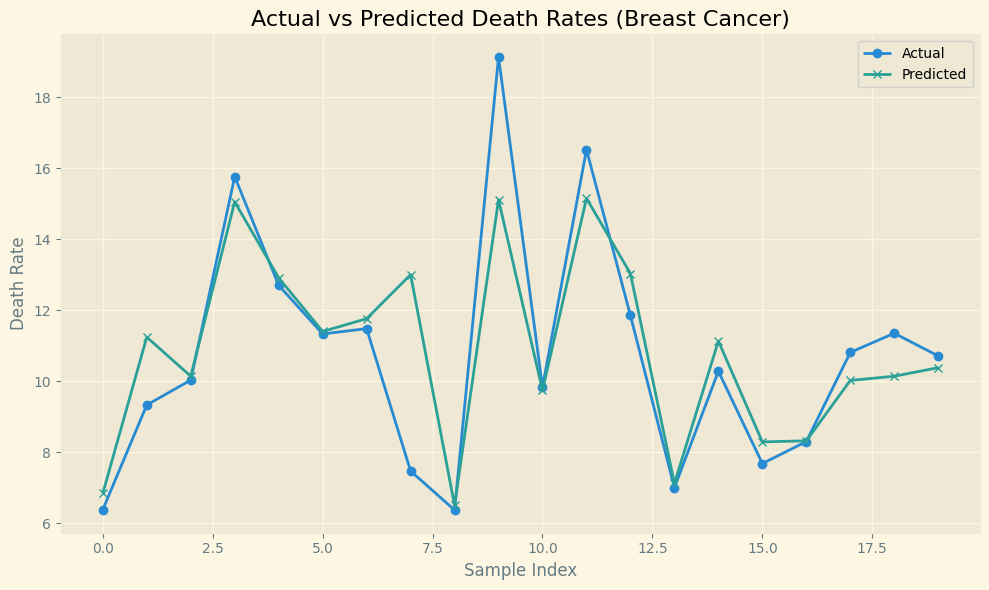

In [ ]:
#Plot actual vs predicted for Breast Cancer
plt.figure(figsize=(10, 6))
plt.plot(breast_cancer_results['Actual Death Rate'].values[:20], label='Actual', marker='o')
plt.plot(breast_cancer_results['Predicted Death Rate'].values[:20], label='Predicted', marker='x')
plt.title('Actual vs Predicted Death Rates (Breast Cancer)')
plt.xlabel('Sample Index')
plt.ylabel('Death Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Decision Tree

In [ ]:


# Melt and clean the dataset
df_cancertype_melt = pd.melt(df, id_vars=['Entity', 'Code', 'Year'], var_name='cancer_type', value_name='survival_rate')
df_cancertype_melt = df_cancertype_melt.dropna()

# Encode categorical features
df_cancertype_melt['cancer_type_code'], _ = pd.factorize(df_cancertype_melt['cancer_type'])
df_cancertype_melt['entity_code'], _ = pd.factorize(df_cancertype_melt['Entity'])

# Define features and target
X = df_cancertype_melt[['cancer_type_code', 'entity_code']]
y = df_cancertype_melt['death_rate']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
model1 = DecisionTreeRegressor(max_depth=10, random_state=42)
model1.fit(X_train, y_train)

# Predict and evaluate
predictions1 = model1.predict(X_test)
mse_dec = mean_squared_error(y_test, predictions1)
mape1_dec = mean_absolute_percentage_error(y_test, predictions1)

print(f"Mean Squared Error: {mse_dec:.2f}")
print(f"Mean Absolute Percentage Error: {mape1_dec:.2f}")


Mean Squared Error: 16.78
Mean Absolute Percentage Error: 0.64


In [ ]:
meta = df_cancertype_melt.loc[y_test.index, ['Entity', 'cancer_type']]
death_rate_breastcancer = meta.copy()
death_rate_breastcancer['Actual Death Rate'] = y_test.values
death_rate_breastcancer['Predicted Death Rate'] = predictions1
death_rate_breastcancer = death_rate_breastcancer.round(2)

# Filter for Breast Cancer
breast_cancer_results = death_rate_breastcancer[death_rate_breastcancer['cancer_type'].str.contains('breast cancer', case=False)]

# Display results

html_table= breast_cancer_results.to_html(index=False)
display(HTML( html_table))

Entity,cancer_type,Actual Death Rate,Predicted Death Rate
Panama,Breast cancer (deaths),6.38,15.25
Nigeria,Breast cancer (deaths),9.33,11.56
Cameroon,Breast cancer (deaths),10.03,10.03
Gabon,Breast cancer (deaths),15.76,12.70
Northern Mariana Islands,Breast cancer (deaths),12.70,11.56
Central African Republic,Breast cancer (deaths),11.33,10.03
Samoa,Breast cancer (deaths),11.48,11.14
Zimbabwe,Breast cancer (deaths),7.47,12.08
Mexico,Breast cancer (deaths),6.37,6.50
Malta,Breast cancer (deaths),19.13,16.35


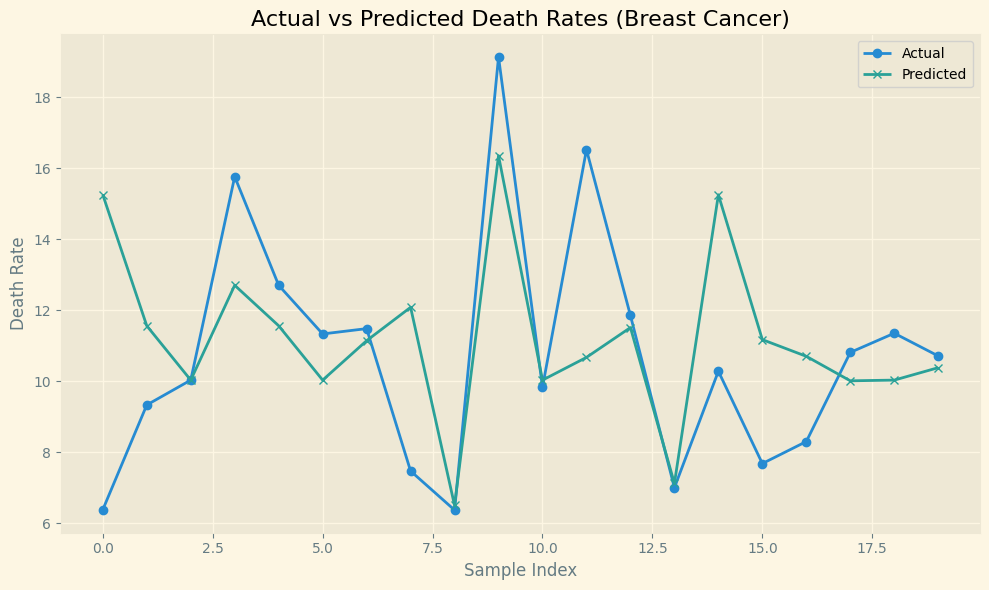

In [ ]:
#Plot actual vs predicted for Breast Cancer
plt.figure(figsize=(10, 6))
plt.plot(breast_cancer_results['Actual Death Rate'].values[:20], label='Actual', marker='o')
plt.plot(breast_cancer_results['Predicted Death Rate'].values[:20], label='Predicted', marker='x')
plt.title('Actual vs Predicted Death Rates (Breast Cancer)')
plt.xlabel('Sample Index')
plt.ylabel('Death Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()